# This notebook contains multiple examples for running EOS-BPM simulations.
## First you will need to ensure the EOS-BPM source code is in your path (done below)
## You will also need the 4 current profile .mat data files: current1.mat, current2.mat, dz1.mat, and dz2.mat
## These files don't mix well with GitHub so store them somewhere safe on your local machine. You can 
## find the original files stored on VELA (/mnt/md0/Data/currents/).




# Defining detector parameters.
### EOS-BPM simulations use a dictionary called setup, containing all the parameters used in the simulation
### The following parameters are required for all EOS-BPM simulations:
* ctype: str, the crystal material either "GaP" or "ZnTe"
* d: float, the crystal thickness (m)
* y0: float, the probe laser central wavelength
* tp: float, the probe laser FWHM duration
* r0: float, the crystal beamline separation (m)
* fpath: str, the full path to the .mat current data files
* nslice: int, the number of slices to divide the crystal into
* tau: array_like, time axis for the probe laser

## Choosing method of encoding/decoding. 
#### EOS-BPM requires the parameter "method", a string whose value is either "spatial", "eosd", or "eotd"
#### for spatial encoding, spatial decoding, or temporal decoding respectively.
#### Each of these methods requires additional variables for setup. 
#### For spatial encoding:
* angle: float, the probe crossing angle in degrees

#### For spatial decoding or temporal decoding:
* tc: float, the FWHM duration of the chirped probe pulse

## Choosing detection process
### EOS-BPM requires the parameter "process", a string whose value is either "near", "cross", or "bal"
### for near crossed-polarizers, crossed-polarizers, balanced detectors. 
### Any of these processes can be chosen for spatial encoding/decoding, however only crossed polarizers can be used with eotd
### Near crossed polarizers requires the additional parameter "theta", a float whose value is the quarter wave plate angle (deg.)

# Example 1: Spatial Encoding (near crossed polarizers) with current profile input

In [1]:
# Add python modules to path and import
import numpy as np
import sys
# Be sure to include your own path to the python modules
sys.path.insert(0, r'C:\\Users\\khunt\\Documents\\GitHub\\plasma-source\\khuntstone\\eos_bpm\\python\\')
sys.path.insert(0, "/home/keenan/plasma-source/khuntstone/eos_bpm/python/")
import currents as cp
import eo_signal as eos
from plotting import plot_signal

In [2]:
import numpy as np
from scipy.constants import c
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
import currents as cp
from crystal import crystal
from laser import laser
import phase_retard as pr
from plotting import makefig
import thz

In [3]:
# Create setup dictionary
# NOTE: remember to change fpath to your local machine's directory
#cpath = "/media/keenan/Data_Storage/Data/currents/"
cpath = "/mnt/md0/Data/currents/"
setup = {
    "ctype"   : "gap",
    "d"       : 100e-6,
    "y0"      : 800e-9,
    "tp"      : 30e-15,
    "r0"      : 2.5e-3,
    "fpath"   : cpath,
    "nslice"  : 100,
    "tau"     : np.linspace(-1000, 1000, 1000)*1e-15,
    "method"  : "spatial",
    "process" : "near",
    "angle"   : 15,
    "theta"   : 25 # You can see this causes phase wrapping at certain angles
    
}
ind = 0 # Current profile index to use
sig, t_sig = eos.get_signal(ind, setup)

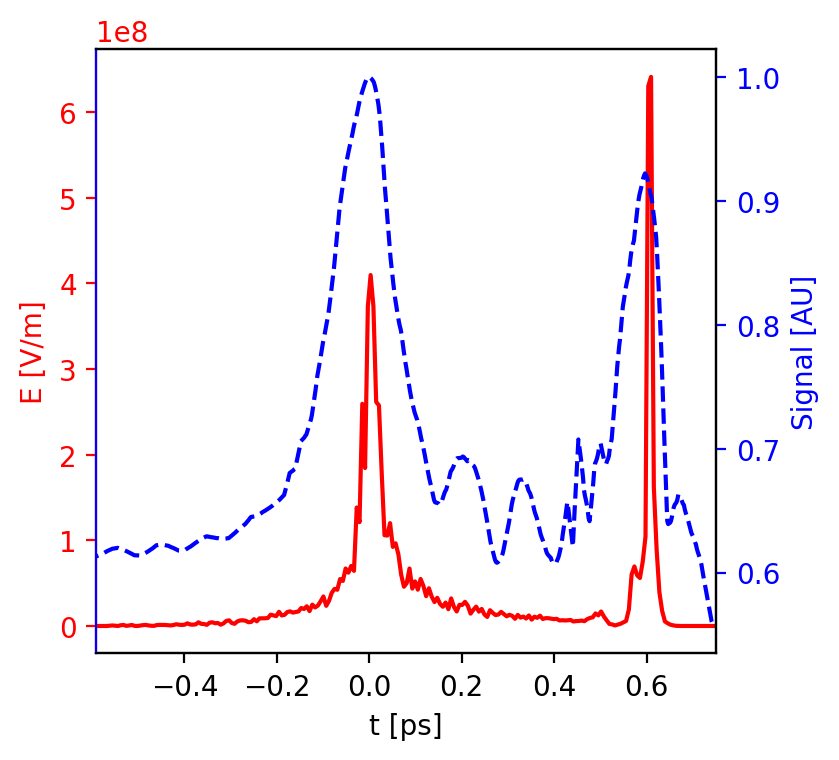

In [4]:
# Get Electric field for plotting
I, ti, p2p = cp.get_current(ind, setup["fpath"])
E, te      = cp.get_E(I, ti, setup["r0"])
plot_signal(E, te, sig, t_sig)

# Example 2: Spatial Decoding (balanced detectors) with electric field input
## EOSD simulations take a little longer as they are propagating the individual components of the chirped pulse.

In [5]:
# Create setup dictionary
# NOTE: remember to change fpath to your local machine's directory
setup = {
    "ctype"   : "gap",
    "d"       : 100e-6,
    "y0"      : 800e-9,
    "tp"      : 30e-15,
    "r0"      : 2.5e-3,
    "fpath"   : cpath,
    "nslice"  : 100,
    "tau"     : np.linspace(-500, 3000, 1000)*1e-15,
    "method"  : "eosd",
    "tc"      : 480e-15,
    "process" : "bal",
    
}
ind = 100 # Current profile index to use
sig, t_sig = eos.get_signal(ind, setup)

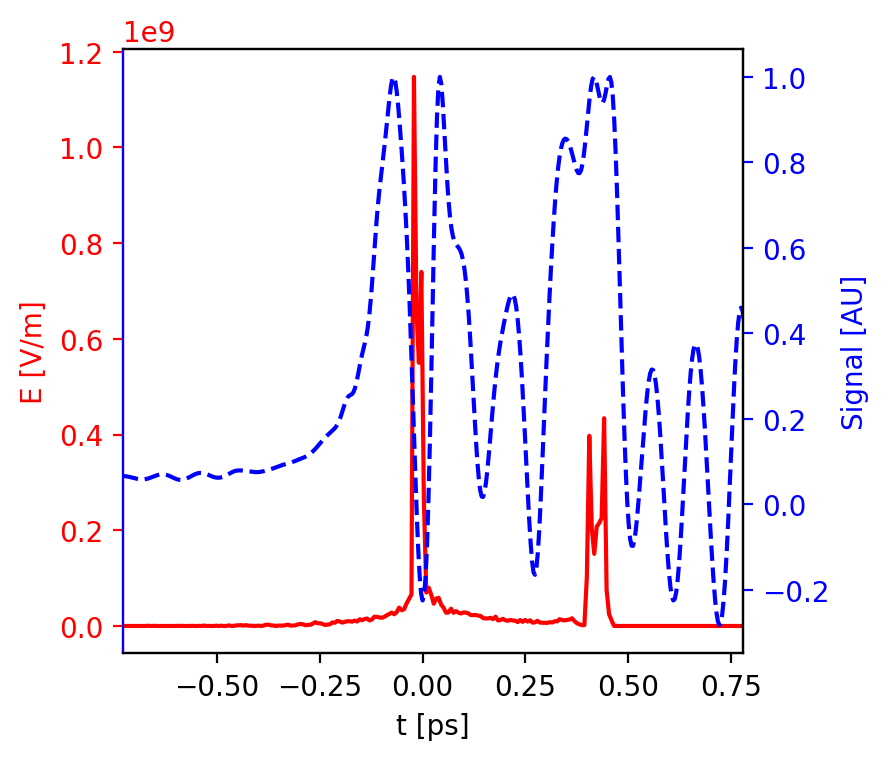

In [6]:
# Get Electric field for plotting
I, ti, p2p = cp.get_current(ind, setup["fpath"])
E, te      = cp.get_E(I, ti, setup["r0"])
plot_signal(E, te, sig, t_sig)

# Example 3: Temporal Decoding (crossed polarizers) with current profile input

In [7]:
# Create setup dictionary
# NOTE: remember to change fpath to your local machine's directory
setup = {
    "ctype"   : "gap",
    "d"       : 100e-6,
    "y0"      : 800e-9,
    "tp"      : 30e-15,
    "r0"      : 2.5e-3,
    "fpath"   : cpath,
    "nslice"  : 100,
    "tau"     : np.linspace(-500, 3000, 1000)*1e-15,
    "method"  : "eotd",
    "tc"      : 480e-15,
    "process" : "cross",   
}
ind = 100 # Current profile index to use
sig, t_sig = eos.get_signal(ind, setup)

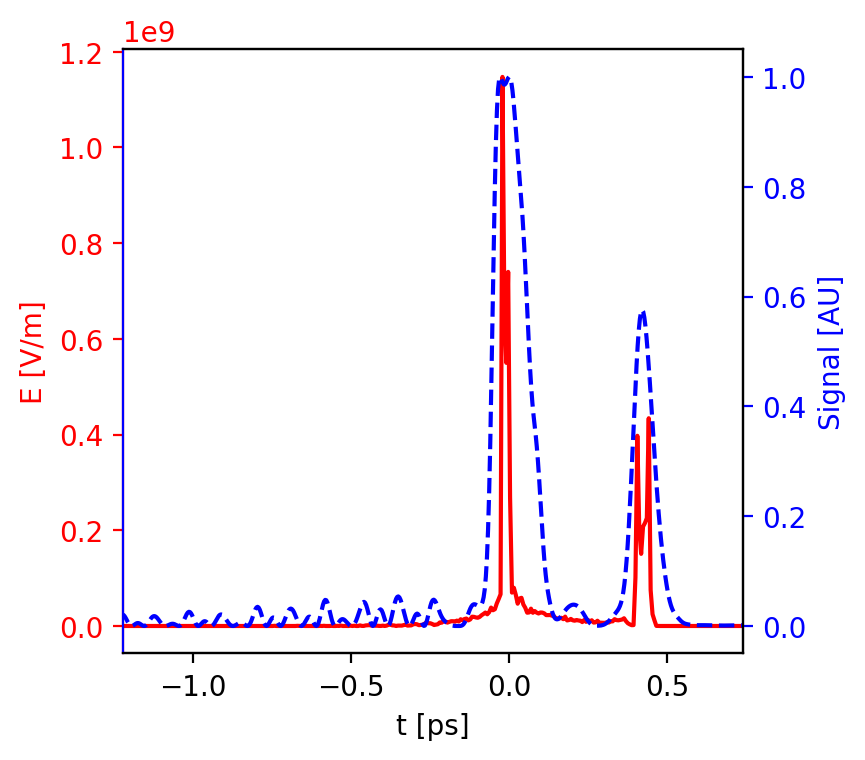

In [8]:
# Get Electric field for plotting
I, ti, p2p = cp.get_current(ind, setup["fpath"])
E, te      = cp.get_E(I, ti, setup["r0"])
plot_signal(E, te, sig, t_sig)

# Example 4: Reconstructing transverse offset
## The beam's transverse offset can be reconstructed for a crossed polarizers
## process. 

In [9]:
# Create setup dictionary, ensure cpath is correct
cpath = "/mnt/md0/Data/currents/"
ind   = 10
r0    = 2.5e-3
setup = {
    "ctype"   : "gap",
    "d"       : 100e-6,
    "y0"      : 800e-9,
    "tp"      : 30e-15,
    "r0"      : 2.5e-3,
    "fpath"   : cpath,
    "nslice"  : 100,
    "tau"     : np.linspace(-1000, 1000, 1000)*1e-15,
    "method"  : "spatial",
    "process" : "cross",
    "angle"   : 15,
    "theta"   : 25 # You can see this causes phase wrapping at certain angles
    
}
# Set offset
dx = 1.0e-6
# Compute near crystal signal
setup["r0"]  = 2.5e-3 - dx
siga, t_siga = eos.get_signal(ind, setup)
# Comptue far crystal signal
setup["r0"]  = 2.5e-3 + dx
sigb, t_sigb = eos.get_signal(ind, setup)
# Reconstruct offset as a percentage
dx_comp = eos.get_offset(siga, sigb, 2.5e-3)
delta   = dx_comp / r0

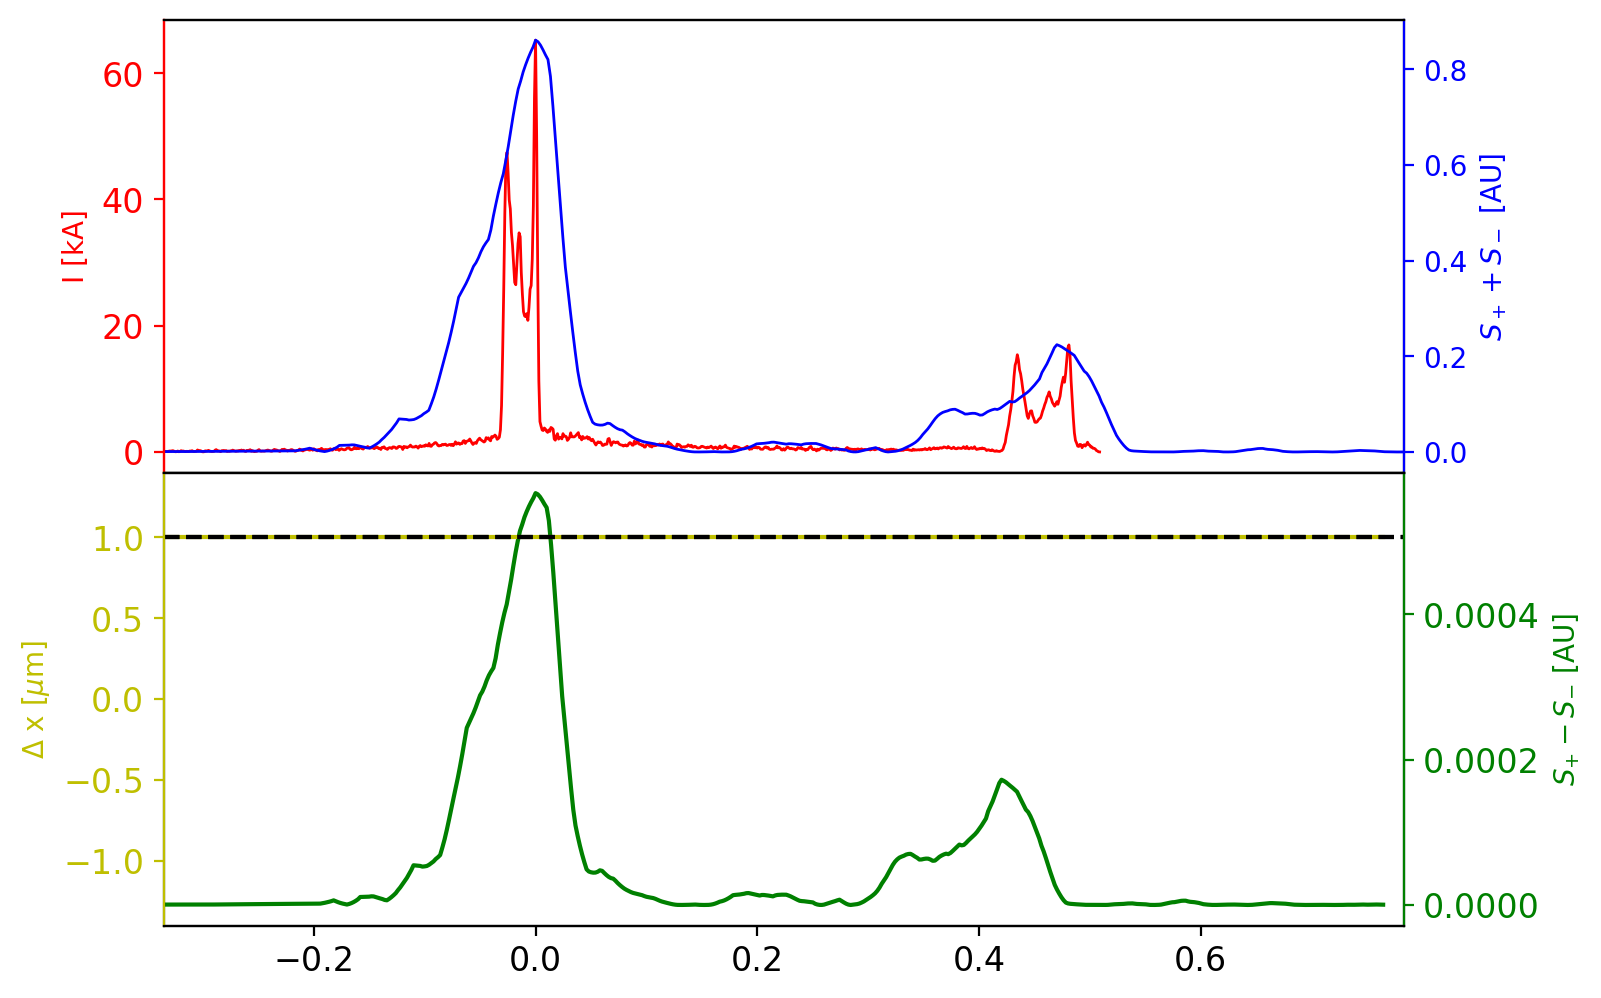

In [10]:
# For plotting load the current profile used
I, ti, p2p = cp.get_current(ind, cpath)
eos.plot_shot(I, ti, siga, sigb, t_siga, delta, dx, dx, 15, r0)